# py4DSTEM tutorial 2: Vacuum probes

A vacuum probe is important for analyzing most crystalline data, where its used as a template to match/find the Bragg disk positions.  py4DSTEM supports 3 methods of vacuum probe extraction - from a vacuum scan, from a vacuum region, and synthetically.  Here, we'll get a vacuum probe from a vacuum region of our scan.

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, save

In [22]:
# Load data

fp = "/Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/sample_processing_file2.h5"
dc = py4DSTEM.file.io.read(fp)

/Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/sample_processing_file2.h5 is a py4DSTEM file, v0.6. Reading...


### Get the average vacuum probe

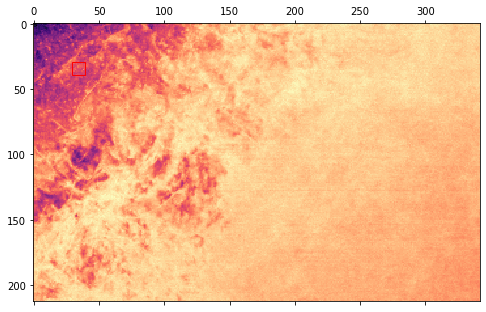

In [24]:
# Select ROI

xmin,xmax=30,40
ymin,ymax=30,40

ROI = np.zeros_like(dc.data[:,:,0,0],dtype=bool)
ROI[xmin:xmax,ymin:ymax] = True

# Display
ave_im = np.average(dc.data,axis=(2,3))
roi_rect = Rectangle(xy=(ymin-0.5,xmin-0.5),width=ymax-ymin,height=xmax-xmin,fill=False,color='r')

fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(ave_im,cmap='magma')
ax.add_patch(roi_rect)
plt.show()

In [25]:
# Get average, shift-corrected probe from ROI
# This step can take a little time, as shift correction requires taking FFTs

mask_threshold = 0.2
mask_expansion = 12
mask_opening = 3
verbose = False

probe = get_average_probe_from_ROI(dc, ROI=ROI,
                                       mask_threshold=mask_threshold,
                                       mask_expansion=mask_expansion,
                                       mask_opening=mask_opening,
                                       verbose=verbose)

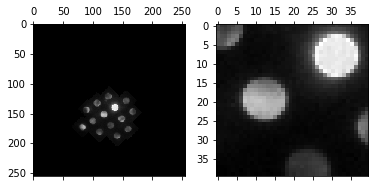

In [26]:
# Show average probe

rad = 20                              # For zoomed-in display
xCoM_init,yCoM_init = get_CoM(probe)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe,cmap='gray')
ax2.matshow(probe[int(xCoM_init)-rad:int(xCoM_init)+rad,int(yCoM_init)-rad:int(yCoM_init)+rad])
plt.show()

### Create vacuum probe kernel

Here, we turn the vacuum probe into a convolution kernel for the later template-matching step.

In [27]:
sigma_probe_scale=4

probe_kernel = get_probe_kernel_subtrgaussian(probe, sigma_probe_scale=sigma_probe_scale)

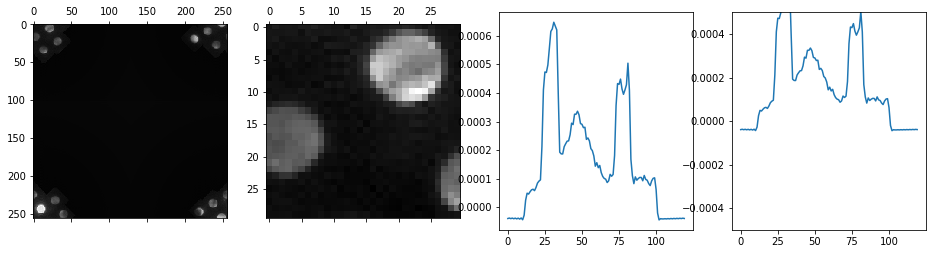

In [28]:
# Display probe_kernel, with line profile

rad=30
lineprofile_length=60
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(dc.Q_Nx,dc.Q_Ny))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(16,4))
ax1.matshow(probe_kernel)
ax2.matshow(probe_kernel[:rad,:rad])
ax3.plot(np.arange(len(line_profile)),line_profile)
ax4.plot(np.arange(len(line_profile)),line_profile)
ax4.set_ylim(-0.0005,0.0005)
plt.show()

### Save

In [29]:
data = np.zeros((dc.Q_Nx,dc.Q_Ny,2))
data[:,:,0] = probe
data[:,:,1] = probe_kernel

probekernel_diffslice = DiffractionSlice(data=data, name='probe',slicelabels=['probe','probe_kernel'])

In [30]:
# Save

savepath = "/Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/Sample_LFP_datacube_processing.h5"
save(probekernel_diffslice,savepath)

Creating file /Users/akshay/Google Drive/Data Analysis/py4DSTEM/py4DSTEM/notebooks/module_demos/dpc/Sample_LFP_datacube_processing.h5...
Done.
